In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.preprocessing import OneHotEncoder
from sklearn import cross_validation as cv
from sklearn.metrics import roc_auc_score
import xgboost as xgb

%matplotlib inline

# helper functions

In [2]:
# function to process the dataset
def process(fname, people_path='./data/people.csv'):
    # load the dataset
    activity = pd.read_csv(fname, parse_dates=['date'])
    people = pd.read_csv(people_path, parse_dates=['date'])
    
    # fill NaN values in activity
    activity = activity.fillna('type 0')
    # rename column names in people
    people.columns = people.columns.map(lambda col: col if 'char' not in col 
                                                        else col[:5] + str(int(col[5:]) + 10))
    
    # drop the date column in people
    people = people.drop('date', axis=1)
    # merge the activity and people files
    data = pd.merge(activity, people, how='left', on=['people_id'])
    # delete to save memory
    del [people, activity]
    # drop columns
    data.drop(['people_id', 'activity_id'], axis=1, inplace=True)
    
    # delete useless words
    columns = ['char_' + str(i) for i in range(1, 20)] + ['activity_category', 'group_1']
    for i in columns:
        data[i] = data[i].apply(lambda x: x.split(' ')[1])
    
    data[data.columns[1:]] = data[data.columns[1:]].astype(int)
    
    # determine wheter or not is weekend
    data['isWeekend'] = (data['date'].dt.weekday >= 5).astype(int)
    data = data.drop('date', axis=1)
    
    return data

In [3]:
# see the number of unique values for each column
def uniqueValue(data, threshold=100):
    """ function to find the unique values """
    for i in data.columns:
        unique = data[i].unique()
        if len(unique) > 2:
            if len(unique) < threshold:
                print(i, len(unique), sorted(unique))
            else:
                print(i, len(unique))
                visualizeDist(data, i, bins=100)

In [4]:
def visualizeDist(data, feature, bins=100, figsize=(8, 3)):
    """ function to visualize the distribution of the feature """
    positive = train[train['outcome'] == 1]
    negative = train[train['outcome'] == 0]
    
    plt.figure(figsize=figsize)
    plt.title("Distribution of " + feature)
    plt.hist(positive[feature].values, bins=bins, color='r', alpha=0.4, label='Positive')
    plt.hist(negative[feature].values, bins=bins, color='g', alpha=0.4, label='Negative')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Process the data

### Load the dataset

In [5]:
# read training and test set
train = process('./data/act_train.csv')
test = process('./data/act_test.csv')

In [6]:
# All feature names
train.columns

Index(['activity_category', 'char_1', 'char_2', 'char_3', 'char_4', 'char_5',
       'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'outcome', 'char_11',
       'group_1', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16',
       'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22',
       'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28',
       'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34',
       'char_35', 'char_36', 'char_37', 'char_38', 'char_39', 'char_40',
       'char_41', 'char_42', 'char_43', 'char_44', 'char_45', 'char_46',
       'char_47', 'char_48', 'isWeekend'],
      dtype='object')

In [7]:
print("Negative Data: ", len(train[train['outcome'] == 0]))
print("Positive Data: ", len(train[train['outcome'] == 1]))

Negative Data:  1221794
Positive Data:  975497


## Study the characteristics of the dataset

### Unique values for each feature

activity_category 7 [1, 2, 3, 4, 5, 6, 7]
char_1 52


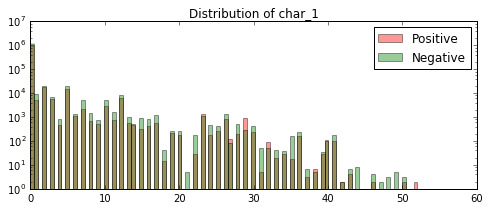

char_2 33


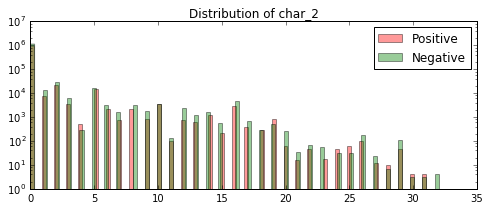

char_3 12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
char_4 8 [0, 1, 2, 3, 4, 5, 6, 7]
char_5 8 [0, 1, 2, 3, 4, 5, 6, 7]
char_6 6 [0, 1, 2, 3, 4, 5]
char_7 9 [0, 1, 2, 3, 4, 5, 6, 7, 8]
char_8 19 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
char_9 20


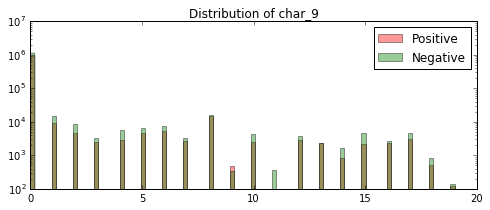

char_10 6516


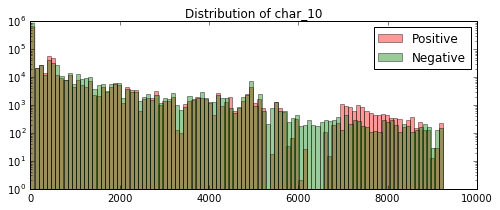

group_1 29899


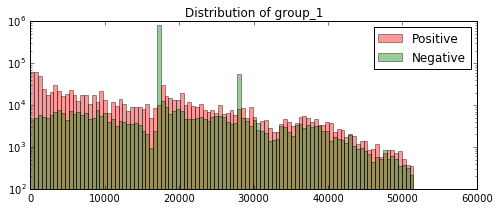

char_12 3 [1, 2, 3]
char_13 43


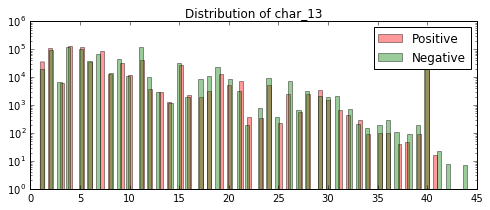

char_14 25


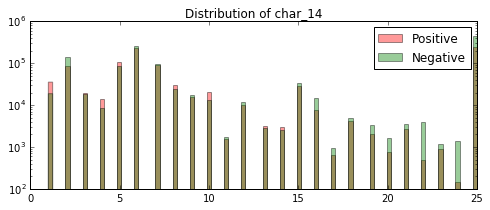

char_15 9 [1, 2, 3, 4, 5, 6, 7, 8, 9]
char_16 7 [1, 2, 3, 4, 5, 6, 7]
char_17 25


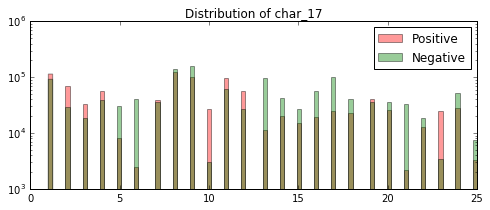

char_18 8 [1, 2, 3, 4, 5, 6, 7, 8]
char_19 9 [1, 2, 3, 4, 5, 6, 7, 8, 9]
char_48 101


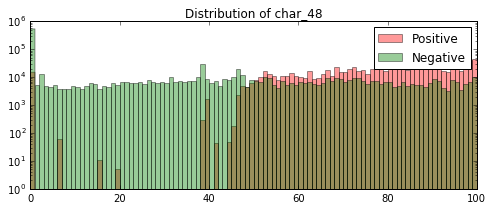

In [8]:
# uniqueValue(train, threshold=20)

In [9]:
# # carefully deal with the feature: "char_48"
# threshold = 46
# train['char_48'] = (train['char_48'] > threshold).astype(int)
# test['char_48'] = (test['char_48'] > threshold).astype(int)

In [10]:
y_train_total = train['outcome']

In [11]:
# one-hot-key encorder
hotFeatures = ['activity_category', 'group_1'] \
            + ['char_' + str(i) for i in range(1, 10)] \
            + ['char_' + str(i) for i in range(12, 20)]
        
noFeatures = []
for i in train.columns:
    if i not in hotFeatures and i != 'outcome':
        noFeatures.append(i)

In [12]:
encorder = OneHotEncoder()
hotTrain = encorder.fit_transform(train[hotFeatures])
hotTest = encorder.transform(test[hotFeatures])

X_train_total = hstack((hotTrain, train[noFeatures]))
X_test = hstack((hotTest, test[noFeatures]))

In [13]:
print("Training set: ", X_train_total.shape)
print("Test set: ", X_test.shape)

Training set:  (2197291, 30234)
Test set:  (498687, 30234)


# Start Learning

### Random State

In [14]:
random_state = 42

### Split the training set

In [15]:
(X_train, X_cv, y_train, y_cv) = cv.train_test_split(X_train_total, y_train_total, test_size=0.3, 
                                                     random_state=random_state)

### Train the classifier

In [16]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_cv = xgb.DMatrix(X_cv, label=y_cv)

In [17]:
param = {'booster': 'gblinear',
         'max_depth': 10,
         'eta': 0.05,
         'silent': 0,
         'objective': 'binary:logistic',
         'nthread': 2,
         'eval_metric': 'auc',
         'colsample_bytree': 0.8,
        #'lambda':5,
        #'lambda_bias':0,
        #'alpha':1
        }

num_round = 300
watchlist = [(xg_train, 'train'), (xg_cv, 'CV')]
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-auc:0.903272	CV-auc:0.903037
[1]	train-auc:0.925321	CV-auc:0.924945
[2]	train-auc:0.943592	CV-auc:0.943078
[3]	train-auc:0.957956	CV-auc:0.957377
[4]	train-auc:0.969105	CV-auc:0.968468
[5]	train-auc:0.977136	CV-auc:0.976460
[6]	train-auc:0.982578	CV-auc:0.981873
[7]	train-auc:0.986140	CV-auc:0.985418
[8]	train-auc:0.988474	CV-auc:0.987747
[9]	train-auc:0.990074	CV-auc:0.989350
[10]	train-auc:0.991249	CV-auc:0.990530
[11]	train-auc:0.992154	CV-auc:0.991441
[12]	train-auc:0.992874	CV-auc:0.992168
[13]	train-auc:0.993459	CV-auc:0.992761
[14]	train-auc:0.993941	CV-auc:0.993248
[15]	train-auc:0.994345	CV-auc:0.993657
[16]	train-auc:0.994687	CV-auc:0.994006
[17]	train-auc:0.994982	CV-auc:0.994306
[18]	train-auc:0.995237	CV-auc:0.994566
[19]	train-auc:0.995458	CV-auc:0.994790
[20]	train-auc:0.995653	CV-auc:0.994988
[21]	train-auc:0.995825	CV-auc:0.995162
[22]	train-auc:0.995976	CV-auc:0.995315
[23]	train-auc:0.996110	CV-auc:0.995452
[24]	train-auc:0.996230	CV-auc:0.995573
[25]	train

In [18]:
# CV evaluation
train_pred = bst.predict(xg_train)
cv_pred = bst.predict(xg_cv)
print("Train: ", roc_auc_score(y_train, train_pred))
print("CV: ", roc_auc_score(y_cv, cv_pred))

Train:  0.997346998475
CV:  0.996644831024


### Create output file

In [19]:
xg_train_total = xgb.DMatrix(X_train_total, label=y_train_total)
xg_test_total = xgb.DMatrix(X_test)
bst = xgb.train(param, xg_train_total)
y_pred = bst.predict(xg_test_total)

In [20]:
test_id = pd.read_csv('./data/act_test.csv', usecols=['activity_id'], 
                      dtype={'activity_id': np.str}).values[:, 0]

In [21]:
result = pd.DataFrame({'activity_id': test_id, 'outcome': y_pred})
result.to_csv('./result/xgb_result(initial).csv', index=None)